# Point Transformer
https://github.com/qq456cvb/Point-Transformers

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [2]:
import torch
!pip install open3d 1>/dev/null

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim as optim
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

!pip install ipympl 1>/dev/null
%matplotlib widget

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

In [4]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [5]:
#!git pull

In [6]:
from visuals.visuals_util import visualize_pointcloud, visualize_pointcloud_eval, visualize_pointcloud_eval_three

## Load dataset

In [7]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

In [ ]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
tr_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

## Load model

In [ ]:
%cd /content/gdrive/MyDrive/Developer
# !git clone https://github.com/qq456cvb/Point-Transformers
%cd Point-Transformers

In [ ]:
!pip install -r requirements.txt

### Point Transformer Model

In [11]:
%cd /content/gdrive/MyDrive/Developer/Point-Transformers

/content/gdrive/MyDrive/Developer/Point-Transformers


In [246]:
import torch
import torch.nn as nn
from pointnet_util import PointNetFeaturePropagation, PointNetSetAbstraction
from models.Hengshuang.transformer import TransformerBlock

class TransitionDown(nn.Module):
    def __init__(self, k, nneighbor, channels):
        super().__init__()
        self.sa = PointNetSetAbstraction(k, 0, nneighbor, channels[0], channels[1:], group_all=False, knn=True)

    def forward(self, xyz, points):
        return self.sa(xyz, points)


class TransitionUp(nn.Module):
    def __init__(self, dim1, dim2, dim_out):
        class SwapAxes(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                return x.transpose(1, 2)

        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim1, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(dim2, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fp = PointNetFeaturePropagation(-1, [])

    def forward(self, xyz1, points1, xyz2, points2):
        feats1 = self.fc1(points1)
        feats2 = self.fc2(points2)
        feats1 = self.fp(xyz2.transpose(1, 2), xyz1.transpose(1, 2), None, feats1.transpose(1, 2)).transpose(1, 2)
        return feats1 + feats2


class Backbone(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc1 = nn.Sequential(
            nn.Linear(d_points, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        self.transformer1 = TransformerBlock(32, cfg.model.transformer_dim, nneighbor)
        self.transition_downs = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in range(nblocks):
            channel = 32 * 2 ** (i + 1)
            self.transition_downs.append(TransitionDown(npoints // 4 ** (i + 1), nneighbor, [channel // 2 + 3, channel, channel]))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))
        self.nblocks = nblocks

    def forward(self, x):
        xyz = x[..., :3]
        points = self.transformer1(xyz, self.fc1(x))[0]

        xyz_and_feats = [(xyz, points)]
        for i in range(self.nblocks):
            xyz, points = self.transition_downs[i](xyz, points)
            points = self.transformers[i](xyz, points)[0]
            xyz_and_feats.append((xyz, points))
        return points, xyz_and_feats


class PointTransformerCls(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_c)
        )
        self.nblocks = nblocks

    def forward(self, x):
        points, _ = self.backbone(x)
        res = self.fc2(points.mean(1))
        return res


class PointTransformerSeg(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 32 * 2 ** nblocks)
        )
        self.transformer2 = TransformerBlock(32 * 2 ** nblocks, cfg.model.transformer_dim, nneighbor)
        self.nblocks = nblocks
        self.transition_ups = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in reversed(range(nblocks)):
            channel = 32 * 2 ** i
            self.transition_ups.append(TransitionUp(channel * 2, channel, channel))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))

        self.fc3 = nn.Sequential(
            nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, n_c)
        )

    def forward(self, x):
        points, xyz_and_feats = self.backbone(x)
        xyz = xyz_and_feats[-1][0]
        points = self.transformer2(xyz, self.fc2(points))[0]

        for i in range(self.nblocks):
            points = self.transition_ups[i](xyz, points, xyz_and_feats[- i - 2][0], xyz_and_feats[- i - 2][1])
            xyz = xyz_and_feats[- i - 2][0]
            points = self.transformers[i](xyz, points)[0]

        return self.fc3(points)

In [247]:
# from models.Hengshuang.model import PointTransformerSeg

class DotDict:
  pass

cfg = DotDict()
cfg.num_point = 2048
cfg.model = DotDict()
cfg.model.nneighbor=32
cfg.model.nblocks=4
cfg.model.transformer_dim=512
cfg.num_class=3
cfg.input_dim = 3

model = PointTransformerSeg(cfg)
_ = model.to(device)

# Losses
training_losses = []
val_losses = []
linearize_input = False

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total params: {total_params}, trainable params: {trainable_params}")

total params: 19393699, trainable params: 19393699


In [115]:
def add_random_noise(point_cloud, mean=0, std=0.025, device="cuda"):
    noise = torch.normal(mean, std, size=point_cloud.size()).to(device)
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [116]:
from pytorch3d.loss.chamfer import chamfer_distance

def residuals_chamfer_distance(ground_truth, input, residual):
  return chamfer_distance(ground_truth, input + residual)[0]

In [117]:

pc = tr_dataset[0]["train_points"].to(device)
print(MSELoss()(pc, add_random_noise(pc, 0.025)))
print(MSELoss()(pc, add_random_noise(pc, 0.05)))

tensor(0.0012, device='cuda:0')
tensor(0.0031, device='cuda:0')


In [118]:
from torch.nn import MSELoss

def residual_l2_loss(ground_truth, input, residual):
  return MSELoss()(ground_truth, input + residual)


print(residual_l2_loss(pc, add_random_noise(pc), add_random_noise(torch.zeros(size=pc.shape).to(device))))

tensor(0.0012, device='cuda:0')


## Overfit model as an autoencoder on single point cloud with noise



In [248]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_ = model.to(device)

In [249]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

In [284]:
# TensorBoard Logging with model's name and current date
import functools

residual_loss_fct = residuals_chamfer_distance
# residual_loss_fct = residual_l2_loss

noise_fct = functools.partial(add_random_noise, std=0.05)

# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)

for epoch in range(100):
    # Train
    model.train()

    # Overfit on single pointcloud
    input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)
    noised_input = noise_fct(input)
    # print(noised_input[0][0])

    optimizer.zero_grad()
    output = model(noised_input)

    loss = residual_loss_fct(ground_truth=input, input=noised_input, residual=output)

    loss.backward()
    optimizer.step()

    epoch_train_loss = loss.item()
    training_losses.append(epoch_train_loss)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}")

    lr_scheduler.step()

Epoch 1,  Training Loss: 0.0063
Epoch 2,  Training Loss: 0.0065
Epoch 3,  Training Loss: 0.0064
Epoch 4,  Training Loss: 0.0066
Epoch 5,  Training Loss: 0.0063
Epoch 6,  Training Loss: 0.0064
Epoch 7,  Training Loss: 0.0064
Epoch 8,  Training Loss: 0.0063
Epoch 9,  Training Loss: 0.0062
Epoch 10,  Training Loss: 0.0063
Epoch 11,  Training Loss: 0.0064
Epoch 12,  Training Loss: 0.0064
Epoch 13,  Training Loss: 0.0065
Epoch 14,  Training Loss: 0.0065
Epoch 15,  Training Loss: 0.0063
Epoch 16,  Training Loss: 0.0064
Epoch 17,  Training Loss: 0.0064
Epoch 18,  Training Loss: 0.0064
Epoch 19,  Training Loss: 0.0064
Epoch 20,  Training Loss: 0.0064
Epoch 21,  Training Loss: 0.0064
Epoch 22,  Training Loss: 0.0062
Epoch 23,  Training Loss: 0.0062
Epoch 24,  Training Loss: 0.0066
Epoch 25,  Training Loss: 0.0063
Epoch 26,  Training Loss: 0.0064
Epoch 27,  Training Loss: 0.0065
Epoch 28,  Training Loss: 0.0065
Epoch 29,  Training Loss: 0.0064
Epoch 30,  Training Loss: 0.0063
Epoch 31,  Training

KeyboardInterrupt: 

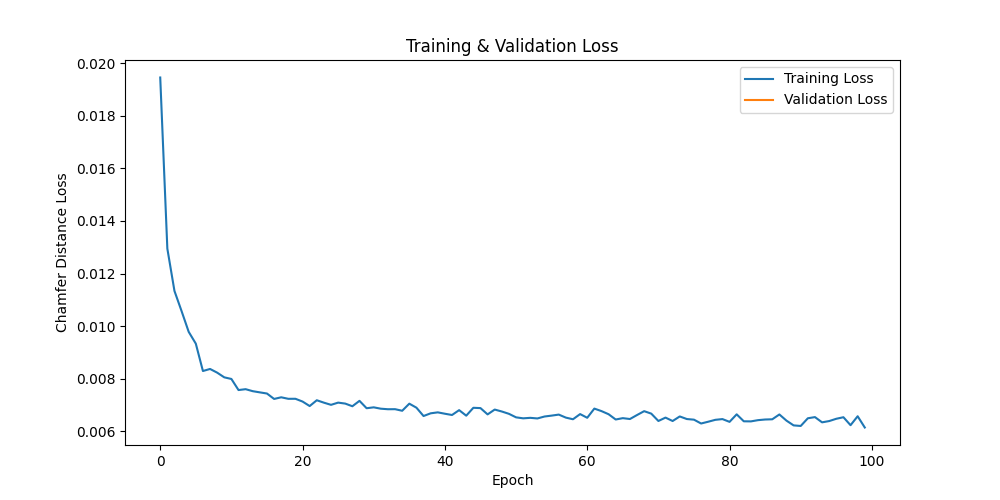

In [251]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

## Visualize example

In [266]:
model.eval()
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)
noised_input = noise_fct(input)

with torch.no_grad():
  output = model(noised_input)

loss = residuals_chamfer_distance(ground_truth=input, input=noised_input, residual=output)
# print(loss)

print(f"`{cfg.num_point=}, {cfg.model.nneighbor=}, {cfg.model.nblocks=}, {cfg.model.transformer_dim=}, {cfg.num_class=}, {cfg.input_dim=}`\n")

print(f"noise CD: `{chamfer_distance(input, noised_input)[0]}`, refined CD: `{chamfer_distance(input, noised_input + output)[0]}`")

`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`

noise CD: `0.007100832648575306`, refined CD: `0.006288414821028709`


`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.002761125098913908, refined CD: 0.003036821261048317`

`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.002727443352341652, refined CD: 0.002919104415923357`

### New input per iteration:
`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.002834647661074996, refined CD: 0.003089092904701829`

### GELU
`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.0028214456979185343, refined CD: 0.00297591183334589`

### noise std=0.05
`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
noise CD: `0.007028569467365742`, refined CD: `0.006310636177659035`

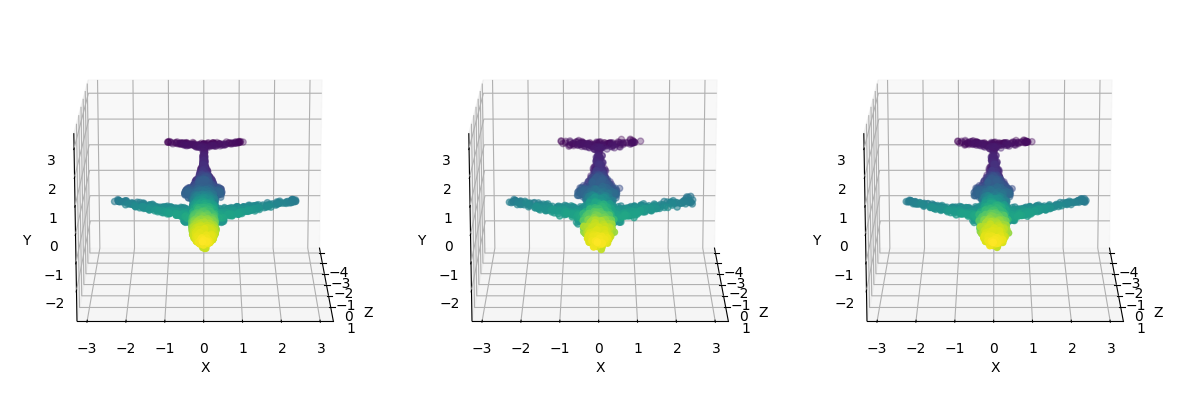

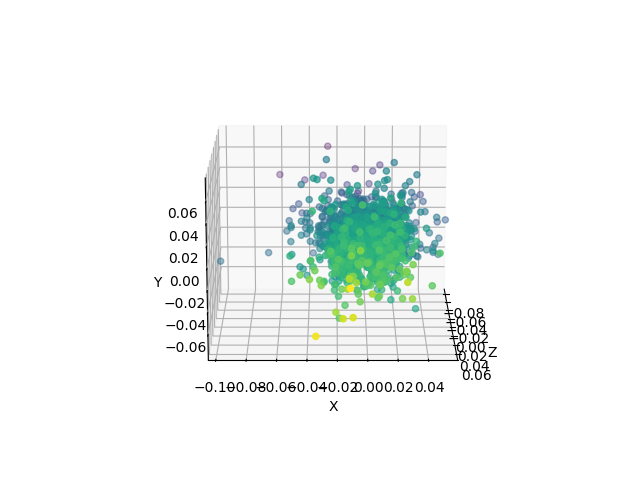

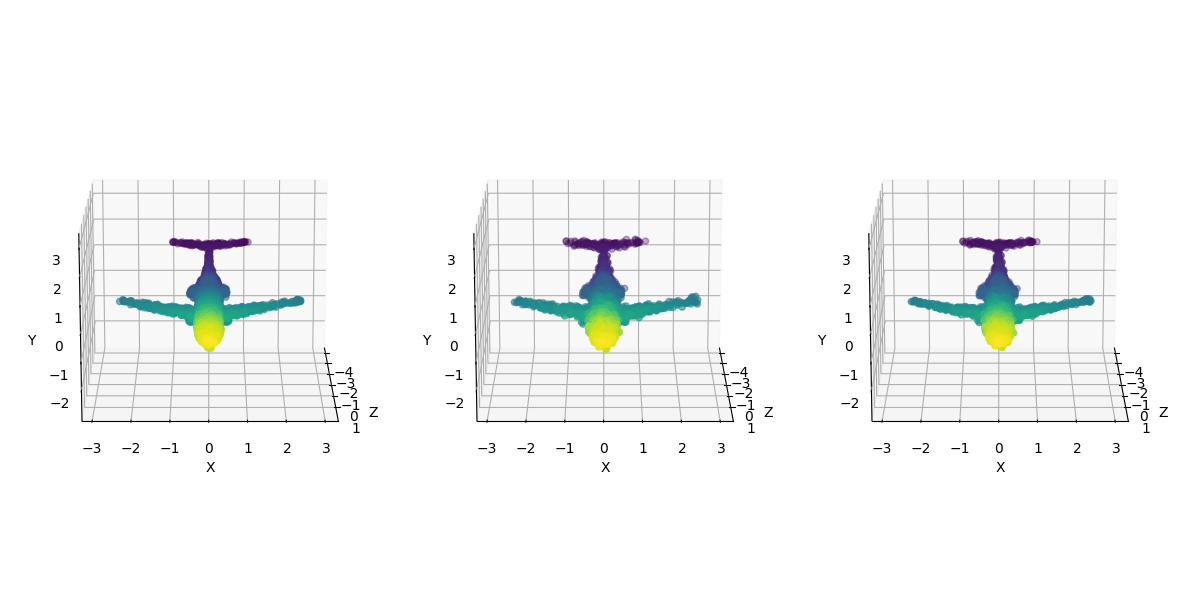

In [256]:
visualize_pointcloud(output.squeeze().cpu())
visualize_pointcloud_eval_three(input.squeeze().cpu(), noised_input.squeeze().cpu(), (noised_input + output).squeeze().cpu())

## Eval with PVD output

In [268]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


{'idx': 0, 'train_points': tensor([[ 0.3831,  0.4918,  0.3978],
        [ 2.3517,  0.1731, -0.1298],
        [-0.1546,  0.2763,  2.1685],
        ...,
        [-2.0821,  0.3289, -0.1267],
        [-1.0950,  0.1934, -0.7673],
        [-1.3184,  0.0303, -0.4485]]), 'test_points': tensor([[-1.2773, -0.0992, -0.2525],
        [-0.0799,  0.1796, -1.5795],
        [-0.9180,  0.2084, -0.5584],
        ...,
        [ 0.2646,  0.0283,  1.2586],
        [-0.1396,  0.3245,  2.3102],
        [-1.3479,  0.1313, -0.1816]]), 'mean': array([[0.00566318, 0.01371725, 0.00985331]], dtype=float32), 'std': array([[0.9827884]], dtype=float32), 'cate_idx': 0, 'sid': '02691156', 'mid': 'train/sample-12'}


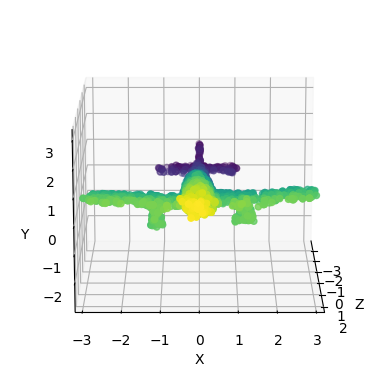

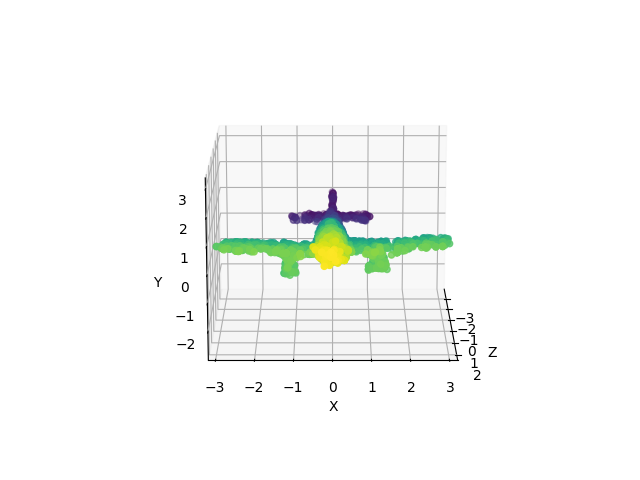

In [274]:
print(dataset_pvd[0])
visualize_pointcloud(dataset_pvd[0]['test_points'])

torch.Size([1, 2048, 3])
(tensor(0.0167, device='cuda:0'), None)


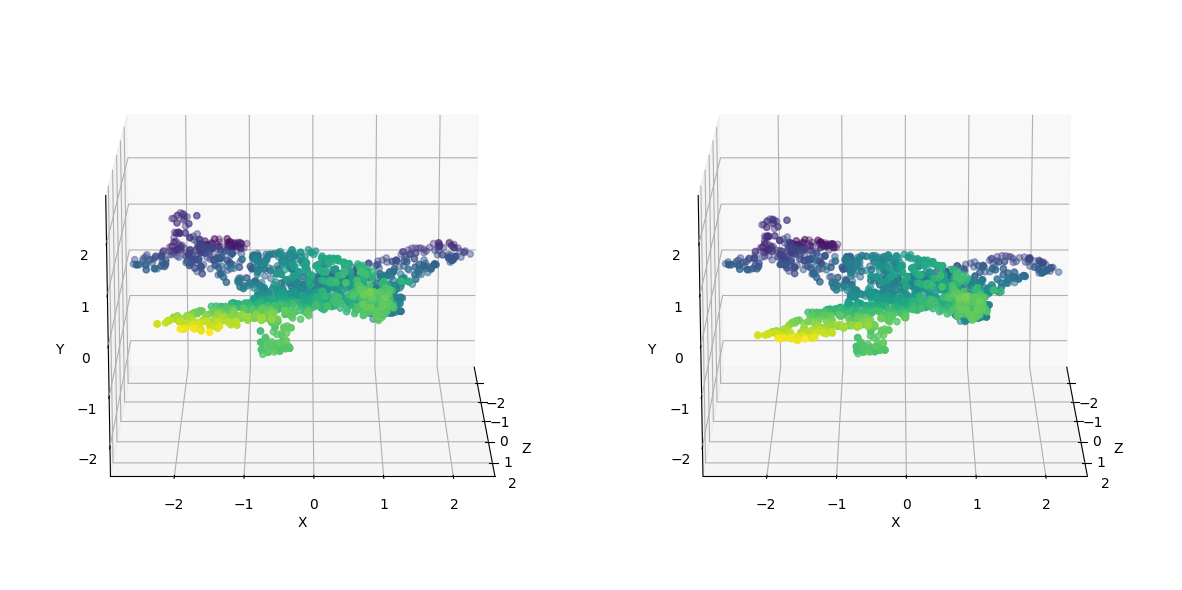

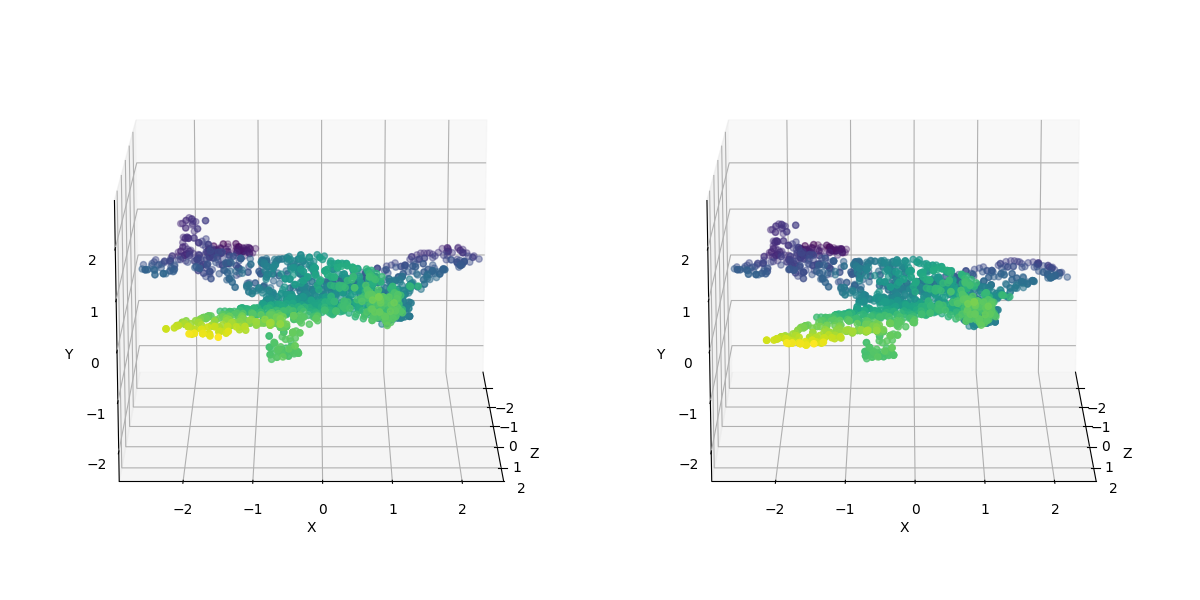

In [283]:
model.eval()

input = dataset_pvd[0]['test_points'].to(device).unsqueeze(0)
print(input.shape)

with torch.no_grad():
  output = model(input)

loss = chamfer_distance(input, input + output)
print(loss)

visualize_pointcloud_eval(rotate_point_cloud_y(input.squeeze().cpu(), 9), rotate_point_cloud_y((input + output).squeeze().cpu(), 45))

In [282]:
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud


In [265]:
# Save the model
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
from datetime import datetime
model_save_path = f"output-models/point_transformer/PointTransformer-{datetime.now().strftime('%Y-%m-%d_%H-%M')}.pth"
torch.save(model.state_dict(), model_save_path)
!git add .
!git status

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
^C
^C


In [ ]:
!git add .
!git commit -m "Add new model"
!git push

In [168]:
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)[:,:1024]
# with torch.no_grad():
#   output = model(noised_input)
# print(input.shape, output.shape)
# visualize_pointcloud(output.cpu())

In [ ]:
input = input.squeeze().cpu()
device="cpu"
visualize_pointcloud_eval_three(input, add_random_noise(input), add_random_noise(input, std=0.1))